In [1]:
!pip install keras-self-attention
!pip install tensorflow-addons
!pip install --upgrade tensorflow
!pip install --upgrade scikit-learn

  Created wheel for keras-self-attention: filename=keras_self_attention-0.42.0-cp36-none-any.whl size=17296 sha256=287934972fcb89026cc986ece021753549efef3143036beb4db4831474ae1d5f
  Stored in directory: /root/.cache/pip/wheels/7b/05/a0/99c0cf60d383f0494e10eca2b238ea98faca9a1fe03cac2894
Successfully built keras-self-attention
Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.2.0rc2)
Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.22.2.post1)


In [2]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense,Dropout,Embedding,LSTM,Bidirectional,Flatten,Conv1D, TimeDistributed,Reshape,Activation,Dot,MaxPool1D,GlobalMaxPool1D
import numpy as np
import pandas as pd
import io
from google.colab import files
from google.colab import drive
from numpy import array
from numpy import asarray
from numpy import zeros
from numpy import random as random
from keras_self_attention import SeqSelfAttention
import keras
import keras.backend as K
import gensim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

Using TensorFlow backend.


In [4]:
from google.colab import drive
drive.mount('/content/drive')
uploaded = files.upload()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
f = '/content/drive/My Drive/sadTextv3 - sadTextv3.csv'
df = pd.read_csv(f, error_bad_lines=False)

In [0]:
df["text"] = df["text"].str.lower()
input_sentences = [text.split(" ") for text in df["text"].values.tolist()]
labels = df["emotion"].values.tolist()
#print(uniquelabels)

Preparing Glove word embeddings using pretrained vectors, 400k words, 100d

In [8]:
word2id=dict()
label2id=dict()
max_words = 0

for sentence in input_sentences:
  for word in sentence:
    word = word.replace(".","")
    if word not in word2id:
      word2id[word] = len(word2id)

    if len(sentence) > max_words:
      max_words = len(sentence)

label2id = {l: i for i, l in enumerate(set(labels))}
id2label = {v:k for k, v in label2id.items()}
id2label



{0: 'shame',
 1: 'neglect',
 2: 'sadness',
 3: 'sympathy',
 4: 'suffering',
 5: 'disappointment'}

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
Y = [label2id[label] for label in labels]
t = Tokenizer()
t.fit_on_texts(input_sentences)
vocab_size = len(t.word_index)+1
print(vocab_size)

encoded_data = t.texts_to_sequences(input_sentences)
padded_data = pad_sequences(encoded_data, max_words)
Y = to_categorical(Y, num_classes=len(label2id), dtype='float32')
print("Shape of X: {}".format(padded_data.shape))
print("Shape of Y: {}".format(Y.shape))
print(t.word_index)

2008
Shape of X: (878, 57)
Shape of Y: (878, 6)
{'i': 1, 'to': 2, 'and': 3, 'my': 4, 'the': 5, 'me': 6, 'a': 7, 'of': 8, 'that': 9, 'it': 10, 'but': 11, 'just': 12, 'in': 13, 'for': 14, 'is': 15, 'have': 16, 'feel': 17, 'this': 18, 'like': 19, 'so': 20, 'you': 21, 'with': 22, 'was': 23, "i'm": 24, 'not': 25, 'be': 26, 'want': 27, 'all': 28, 'im': 29, 'no': 30, 'life': 31, 'do': 32, 'about': 33, 'even': 34, 'myself': 35, 'how': 36, 'because': 37, 'or': 38, 'dont': 39, 'time': 40, 'now': 41, 'at': 42, "don't": 43, 'on': 44, 'never': 45, 'can': 46, 'he': 47, 'when': 48, 'they': 49, 'know': 50, 'really': 51, 'am': 52, 'as': 53, 'people': 54, 'being': 55, 'her': 56, 'if': 57, 'would': 58, 'out': 59, 'one': 60, 'get': 61, 'had': 62, 'from': 63, "can't": 64, 'we': 65, 'been': 66, 'depression': 67, 'up': 68, 'what': 69, 'its': 70, 'she': 71, 'much': 72, 'only': 73, 'are': 74, 'anything': 75, 'could': 76, 'them': 77, 'nothing': 78, 'alone': 79, 'cant': 80, 'has': 81, 'help': 82, 'him': 83, 'mor

In [10]:
from google.colab import drive
from numpy import array
from numpy import asarray
from numpy import zeros
#Loading embedding file into memory
print('Indexing word vectors.')

embeddings_index = {}
f = open('/content/drive/My Drive/glove.6B/glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = vec
f.close()

print('Found %s word vectors.' % len(embeddings_index))


Indexing word vectors.
Found 400000 word vectors.


In [11]:
embedding_matrix  = zeros((vocab_size,300))
for word, i in t.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

print(len(embedding_matrix))

2008


Building Keras Model:

Word Embedding - pretrained Glove, however will try replacing that with bert to perhaps improve results.

BiDirectional LSTM



In [27]:
from tensorflow.keras.layers import Input,Dense,Dropout,Embedding,LSTM,Bidirectional,Flatten,Conv1D,Reshape, TimeDistributed,Reshape,Activation,Dot,MaxPool1D,GlobalMaxPool1D,concatenate,GlobalAveragePooling1D

embedding_dim = 300

inputs=Input(shape=(max_words,),dtype='int32')

xx = Embedding(vocab_size,embedding_dim, weights=[embedding_matrix],input_length=max_words,trainable=False)(inputs)
dr = Dropout(0.2)
xx = Bidirectional((LSTM(embedding_dim,dropout = 0.3,activation='tanh',return_sequences = True)))(xx)

cn = Conv1D(150,3,padding='valid')(xx)
cng = GlobalMaxPool1D()(cn)



fc = Dense(100, activation='relu')(cng)
dr = Dropout(0.2)(fc)
out = Dense(len(label2id), activation = 'softmax')(dr)

model = Model(inputs = [inputs], outputs = out)
model.compile(optimizer='adam',loss='categorical_crossentropy',
              metrics=['accuracy',tf.keras.metrics.Recall(),
                       tf.keras.metrics.Precision(),])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 57)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 57, 300)           602400    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 57, 600)           1442400   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 55, 150)           270150    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 150)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               15100     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0   

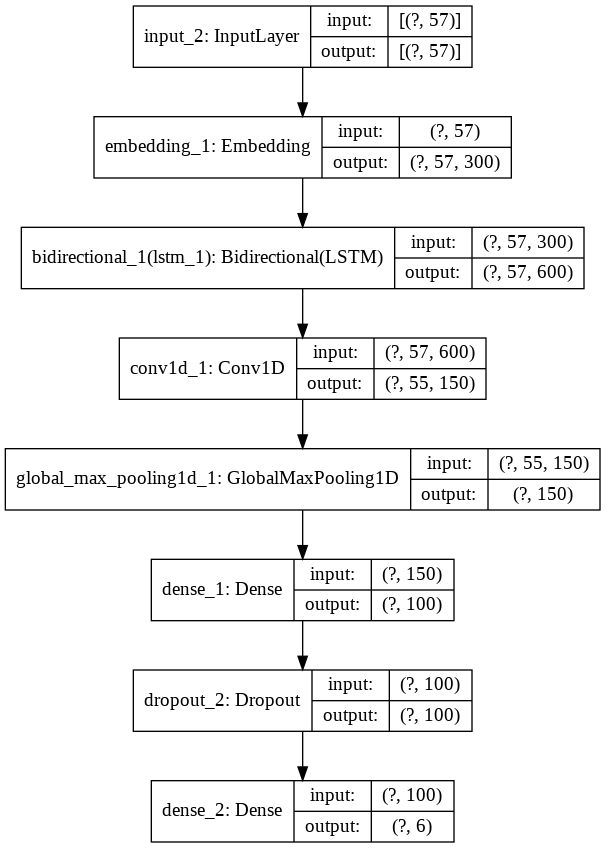

In [14]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')

In [0]:
#Callbacks
def scheduler(epoch):
  if epoch < 20:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.1 * (10 - epoch))

best_epoch = 'weights.{epoch:02d}-{val_accuracy:.2f}.hdf5'
checkpoint =  tf.keras.callbacks.ModelCheckpoint(filepath=best_epoch, monitor='val_accuracy',save_best_only=True,mode='max')
scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15, mode="max")
callbacks = [earlystop,scheduler_callback,checkpoint]


In [30]:


X_train = padded_data[:650]
Y_train = Y[:650]
X_test = padded_data[650:]
Y_test = Y[650:]

model.fit(X_train, Y_train, epochs=100, batch_size=128, validation_split=0.1, shuffle=True, callbacks=callbacks)

Epoch 1/100
5/5 [==============================] - 6s 1s/step - loss: 0.1658 - accuracy: 0.9368 - recall_1: 0.9316 - precision_1: 0.9445 - val_loss: 2.9469 - val_accuracy: 0.3846 - val_recall_1: 0.3846 - val_precision_1: 0.4098 - lr: 0.0010
Epoch 2/100
5/5 [==============================] - 6s 1s/step - loss: 0.1429 - accuracy: 0.9487 - recall_1: 0.9350 - precision_1: 0.9596 - val_loss: 2.7174 - val_accuracy: 0.4000 - val_recall_1: 0.3692 - val_precision_1: 0.4286 - lr: 0.0010
Epoch 3/100
5/5 [==============================] - 9s 2s/step - loss: 0.1119 - accuracy: 0.9675 - recall_1: 0.9641 - precision_1: 0.9707 - val_loss: 2.5547 - val_accuracy: 0.4462 - val_recall_1: 0.4000 - val_precision_1: 0.4407 - lr: 0.0010
Epoch 4/100
5/5 [==============================] - 6s 1s/step - loss: 0.0953 - accuracy: 0.9607 - recall_1: 0.9573 - precision_1: 0.9655 - val_loss: 2.4485 - val_accuracy: 0.4615 - val_recall_1: 0.4308 - val_precision_1: 0.4667 - lr: 0.0010
Epoch 5/100
5/5 [===================

In [0]:

#converting Y_test from one hot encoding for sklearn classification_report
Y_onehot = Y_test.tolist()
Y_true=[]

for items in Y_onehot:
  i=0
  for item in items: 
    if item == 1:
      Y_true.append(i)
      
    else:
      i+=1

In [32]:
#Loading the weights from the best epoch
#model.load_weights('/content/weights.05-0.30.hdf5')

preds=model.predict(X_test, batch_size=32, verbose=1)
pred_classes = np.argmax(preds,axis=1)
labels = ['shame','neglect','sadness',
         'sympathy','suffering','disappointment']
print(classification_report(Y_true,pred_classes,labels=[0,1,2,3,4,5],target_names=labels,digits=4))

8/8 [==============================] - 1s 146ms/step
                precision    recall  f1-score   support

         shame     0.3250    0.2600    0.2889        50
       neglect     0.6667    0.3103    0.4235        58
       sadness     0.0800    0.0690    0.0741        29
      sympathy     0.4815    0.4643    0.4727        28
     suffering     0.3409    0.4688    0.3947        32
disappointment     0.2154    0.4516    0.2917        31

      accuracy                         0.3289       228
     macro avg     0.3516    0.3373    0.3243       228
  weighted avg     0.3873    0.3289    0.3336       228



In [34]:
test_split = 649

labels = df["emotion"].values.tolist()
newpreds = [id2label[item] for item in pred_classes]
print(len(newpreds))
print(len(labels[test_split+1:]))
text=df["text"][test_split+1:].tolist()
print(len(text))
data = {'Text':text, 'Classification':labels[test_split+1:], 'Prediction': newpreds} 
newdf = pd.DataFrame(data)
newdf.to_csv("predscnn.csv")

228
228
228
